# Interactive dEB light curve viewing tool

In [1]:
from pathlib import Path
import re
from ast import literal_eval
from itertools import zip_longest
from copy import deepcopy

import numpy as np
import astropy.units as u
from astroquery.vizier import Vizier
import lightkurve as lk

#%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from deblib.limb_darkening import lookup_pow2_coefficients, lookup_quad_coefficients
from ebop_maven.estimator import Estimator

from libs.lightcurves import load_lightcurves, create_invalid_flux_mask, to_lc_time
from libs.lightcurves import append_magnitude_columns, find_lightcurve_segments, fit_polynomial
from libs.lightcurves import get_sampled_phase_mags_data
from libs.pipeline import append_calculated_inc_predictions

2025-03-13 16:25:13.674087: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 16:25:13.674598: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 16:25:13.676960: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-13 16:25:13.683465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741883113.695370   35727 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741883113.69

In [2]:
tess_ebs_catalog = Vizier(catalog="J/ApJS/258/16", row_limit=1)
gaia_tbosb_catalog = Vizier(catalog="I/357/tbosb2", row_limit=1)
estimator = Estimator()

Estimator loading '/home/steveo/projects/main/platodebcat/.platodebcat/lib/python3.11/site-packages/ebop_maven/data/estimator/default-model.keras'...loaded 'CNN-New-Ext0-bP-4096-None-500k'.
The model CNN-New-Ext0-bP-4096-None-500k was created at 2025-02-17T20:48:17+00:00
The input features are:
  mags_feature as a NDarray[float] of shape (#instances, 4096) containing a phase folded light curve centred on the mid-point between the primary and secondary eclipse
  extra_features as a NDarray of shape (#instances, 0) or None, as no extra_features are used for predictions
The prediction results are:
  predicted values as a structured NDarray[UFloat] of shape (#instances, [rA_plus_rB, k, J, ecosw, esinw, bP])
  optionally, if include_raw is True, all MC predictions as a NDArray[float] of shape (#instances, 6, #iterations)


W0000 00:00:1741883118.601703   35727 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Select your target
The `target` is the object name value used on plots, messages and local cache folder.
The `search_term` is used to search for assets in MAST, which can be object name
(with or without a V* prefix) or a TIC identifier (9 digit numeric value).

In [3]:
default_target = "CW Eri"
display(HBox(children=[
    (target_text := Text(description="target :", value=default_target, placeholder="target name or TIC number")),
    (do_prefix := Checkbox(description="prefix search term with V* unless TIC", value=True, layout={'width': "max-content"} )),
]))

In [4]:
target = f"TIC {int(target_text.value):09d}" if target_text.value.isnumeric() else target_text.value
search_term = f"V* {target}" if not target.startswith("TIC") and do_prefix.value else target
print(f"The chosen target is '{target}' with search_term = '{search_term}'")

The chosen target is 'CW Eri' with search_term = 'V* CW Eri'


### Review Target Information and refine the search

In [5]:
# Find any assets for the target, filtered on TESS timeseries observations
results = lk.search_lightcurve(search_term)
suitability_mask = ((results.author == "SPOC") | (results.author == "TESS-SPOC")) \
                    & (results.table["dataproduct_type_products"] == "timeseries") \
                    & (results.table["obs_collection_products"] != "HLSP") \
                    & np.where(["TESS" in m for m in results.mission], True, False)

fmt = "{0} ({1}, mission={2}, author={3}, target={4}, exptime={5})"
display(VBox(children=(checkboxes := [
    Checkbox(description=fmt.format(r.mission[0], r.year[0], r.table["obs_collection_products"][0], r.author[0], r.target_name[0], r.exptime[0]),
             value=True, layout={'width': "max-content"}) for r in results[suitability_mask]
])))

### Download the light curves of the chosen sectors
For details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The find_lightcurves() function will attempt to service the request from the
local cache in preference to contacting MAST.

In [6]:
display(HBox(children=[
    (flux_column     := widgets.Dropdown(description="flux_column :", options=["sap_flux", "pdcsap_flux"], value="sap_flux", style={'description_width': 'max-content'})),
    (quality_bitmask := widgets.Dropdown(description="quality_bitmask :", options=["default", "hard", "hardest"], value="default", style={'description_width': 'max-content'})),
]))

In [7]:
select_mask = np.array([checkboxes[i].value for i in range(len(checkboxes))], dtype=bool)
lcs = load_lightcurves(results[suitability_mask][select_mask], quality_bitmask.value, flux_column.value,
                       Path.cwd() / ".cache" / re.sub(r"[^\w\d]", "-", target.lower()))

### Plot the selected light curves

In [8]:
def plot_lightcurves(the_lcs, column="flux", normalize=False, add_x=[], add_y=[], cols=2):
    rows = int(np.ceil(len(lcs) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(8, 3*rows), sharey=True, constrained_layout=True)
    axes = [axes] if isinstance(axes, Axes) else axes.flatten()

    for ix, (ax, lc, x, y) in enumerate(zip_longest(axes, the_lcs, add_x, add_y)):
        if ix < len(lcs):
            lc.scatter(ax=ax, column=column, label=None, normalize=normalize)
            if x is not None and y is not None:
                ax.scatter(x, y, c="k", s=0.5, marker=".", alpha=0.5)
            if column == "delta_mag":
                ax.set_ylabel("differential magnitude [mag]")
            if ix == 0 and lc[column].unit == u.mag:
                ax.invert_yaxis()
            ax.set_ylabel(None if ix % cols else ax.get_ylabel())
            ax.set_title(f"{target} sector {lc.meta['SECTOR']} " +
                    f"({lc.meta['FLUX_ORIGIN']} @ {lc.meta['FRAMETIM']*lc.meta['NUM_FRM'] * u.s})")
            ax.tick_params(axis="both", which="both", direction="in",
                           top=True, bottom=True, left=True, right=True)
        else:
            ax.axis("off")
    return fig

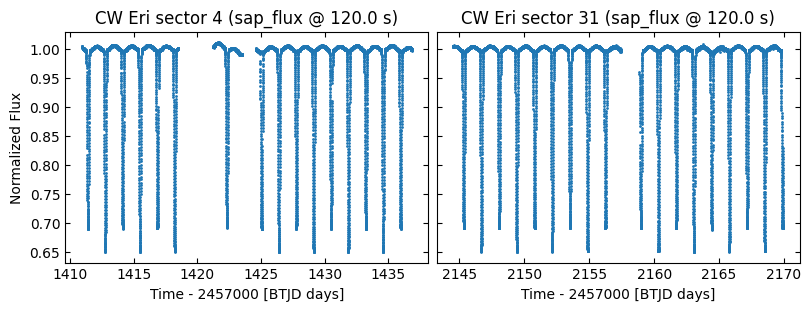

In [9]:
plt.show(fig := plot_lightcurves(lcs, normalize=True))
plt.close(fig)

### Process the light curves to create flattened copies with delta_mag columns

First we select regions to exclude from processing. These could be distorted regions of the
light curve, incomplete eclipses or isolated regions with no useful data. Currently there is
no tool for selecting ranges from the light curve plot directly, so instead we parse the text
of an exclude list of (from, to) time tuples taken from all sectors. For example;
```python
[(1420.0, 1424.0), (2158.0, 2160.0)]
```
where the time values are interpreted with the time format and scale of each light curve.

Once we have any time masks we can use these, along with a simple mask which excludes
invalid flux values, to create masked copies of the original light curves. The masked
light curves are then extended with `delta_mag` and `delta_mag_err` columns calculated
from the fluxes. The `delta_mag` values are detrended and rectified in contiguous segments,
which are selected by finding gaps in the timeseries > gap threshold. Each segment is
rectified and detrended by subtracting a fitted polynomial of the selected degree. 

In [10]:
display(VBox(children=[
    (time_masks_text := Text(description="Time ranges to exclude:", placeholder="[(from, to), (from, to), ...]", layout={'width': "50%"}, style={'description_width': 'max-content'})),
    (seg_gap_th := FloatLogSlider(description="segment gap threshold (d):", base=10, value=2.0, min=-1, max=3, layout={"width": "33%"}, style={'description_width': 'max-content'})),
    HBox(children=[
        (det_degree := IntSlider(description="detrend poly degree:", value=2, min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (det_iterations := IntSlider(description="detrend iterations:", value=2, min=1, max=4, layout={"width": "25%"}, style={'description_width': 'max-content'})),
])]))

In [11]:
time_mask_list = []
if len(time_masks_text.value.strip()): # Interpret the list of (from, to) tuples entered above
    time_mask_list = literal_eval(time_masks_text.value)
    if isinstance(time_mask_list, (tuple, int, float)):
        time_mask_list = [time_mask_list]

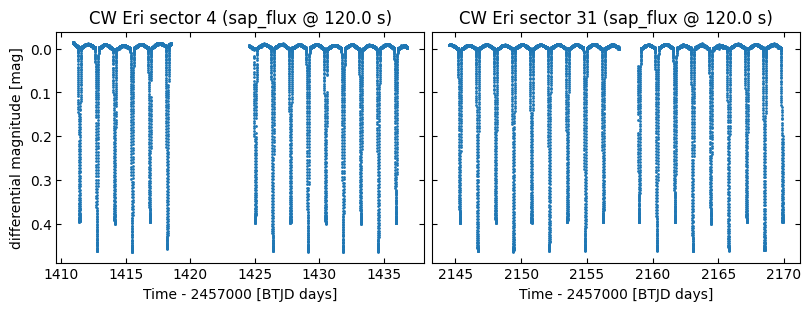

In [12]:
mag_lcs = lk.LightCurveCollection([])
for lc in lcs:
    # Mask out any invalid fluxes and requested time ranges
    qual_mask = create_invalid_flux_mask(lc)
    for time_mask_range in (to_lc_time(t, lc) for t in time_mask_list):
        qual_mask &= (lc.time < np.min(time_mask_range)) | (lc.time > np.max(time_mask_range))

    # Create detrended & rectified delta_mag and delta_mag err columns
    mag_lc = lc[qual_mask]
    append_magnitude_columns(mag_lc, "delta_mag", "delta_mag_err")
    for seg in find_lightcurve_segments(mag_lc, threshold=seg_gap_th.value * u.d):
        mag_lc[seg]["delta_mag"] -= fit_polynomial(mag_lc.time[seg], mag_lc[seg]["delta_mag"],
                                                   det_degree.value, det_iterations.value, 1.0)   

    mag_lcs.append(mag_lc)

plt.show(fig := plot_lightcurves(mag_lcs, column="delta_mag"))
plt.close(fig)

### Review phase folded light curves
First we lookup for the system's ephemeris in the TESS-ebs catalogue based on its TIC. If nothing found then the primary epoch and orbital period must be set manually by inspecting the light curves above.

By default the T0 time is expected to be the time of a primary eclipse. The phase folded light curves will be phase normalized when folded about this point (which becomes phase 0).

In [13]:
default_t0, default_period = None, None
if (result := tess_ebs_catalog.query_object(mag_lcs[0].meta["OBJECT"])):
    default_t0, default_period = result[0]["BJD0"][0], result[0]["Per"][0]
elif (result := gaia_tbosb_catalog.query_object(search_term)):
    default_period = result[0]["Per"][0]

display(HBox(children=[
    (t0_text := FloatText(description="Primary epoch (btjd):",  value=default_t0, style={'description_width': 'max-content'})),
    (period_text := FloatText(description="Orbital period (d):", value=default_period, style={'description_width': 'max-content'})),
]))

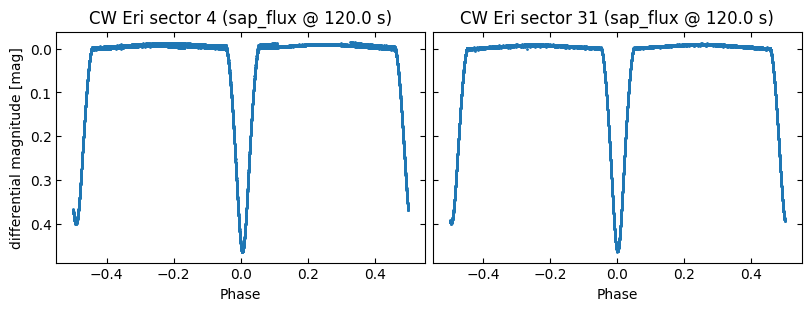

In [14]:
t0 = to_lc_time(t0_text.value, mag_lcs[0])
period = period_text.value * u.d

# Plot folded copies of the mags LCs. By default lk will give these phase ranges [-0.5, 0.5]
# which works well here as we want to be able to judge the phase of the secondary eclipses.
fig = plot_lightcurves((lc.fold(period, t0, normalize_phase=True) for lc in mag_lcs), "delta_mag")
plt.show(fig)
plt.close(fig)

### Create sampled, phase folded mags data for use with EBOP MAVEN
We now need to make sampled copies of phase folded and phase normalized light curves for
each sector. The EBOP MAVEN model will tell us what wrap it expects for the folded light curves
for estimations through its `mags_feature_wrap_phase` attribute. This will have a value between
0 and 1, or `None`;
- a numeric value indicates the phase above which phased data is wrapped
to a negative phase
    - a value of 0.75 indicates a phase range of -0.24999 to 0.75, centred on phase \~0.25
- a value of `None` indicates that the wrap is to be adaptive so that the resulting data
is centred on the mid-point between the primary and secondary eclipse
    - in this case the value must be found by inspection of the light curves above or from a known value
    - for a circular orbit a value of 0.75 centres the phase folded data at this mid-point

In [15]:
mags_wrap_phase = estimator.mags_feature_wrap_phase
if mags_wrap_phase is None:
    display(HBox(children=[
        (wrap_phase_slider := FloatSlider(description="Mags feature wrap phase:", value=.75, min=.01, max=.99, step=.01,
                                          layout={"width": "33%"}, style={'description_width': 'max-content'})),
    ]))

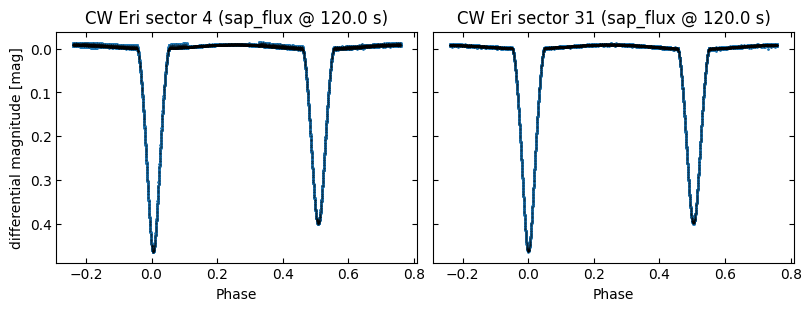

In [16]:
if mags_wrap_phase is None:
    mags_wrap_phase = u.Quantity(wrap_phase_slider.value)
elif not isinstance(mags_wrap_phase, u.Quantity):
    mags_wrap_phase = u.Quantity(mags_wrap_phase)

flcs = []
mags_data = np.zeros(shape=(len(mag_lcs), 2, estimator.mags_feature_bins), dtype=np.float32) # 0: phases, 1: mags
for ix, lc in enumerate(mag_lcs):
    flcs.append(flc := lc.fold(period, t0, wrap_phase=mags_wrap_phase, normalize_phase=True))
    mags_data[ix] = get_sampled_phase_mags_data(flc, estimator.mags_feature_bins, mags_wrap_phase)

# Revised plots of the folded light curves, now wrapped as requested & overlaid with mags features
plt.show(fig := plot_lightcurves(flcs, "delta_mag", add_x=mags_data[:, 0], add_y=mags_data[:, 1]))
plt.close(fig)

### Estimate fitting input parameters with EBOP MAVEN
The EBOP MAVEN model will predict values for $r_{\rm A}+r_{\rm B}$, $k$, $J$, $e\cos{\omega}$,
$e\sin{\omega}$ and $b_{\rm P}$ for use as `JKTEBOP` fitting input parameters. To these we will
need to add values for $i$, which can be calculated from the 6 predicted values.

In [17]:
predictions = estimator.predict(mags_data[:, 1], iterations=1000)
predictions = append_calculated_inc_predictions(predictions)

for lc, preds in zip(mag_lcs, predictions):
    print(f"\nJKTEBOP input parameters for {target} sector {lc.meta['SECTOR']}")
    print(*(f"{p:>12s}: {preds[p] or 0:11.6f}" for p in predictions.dtype.names), sep="\n")


JKTEBOP input parameters for CW Eri sector 4
  rA_plus_rB:    0.305124+/-   0.013993
           k:    0.749876+/-   0.045163
           J:    0.898005+/-   0.031676
       ecosw:    0.006292+/-   0.006059
       esinw:   -0.013604+/-   0.013354
          bP:    0.408172+/-   0.033356
         inc:   85.973370+/-   0.395615

JKTEBOP input parameters for CW Eri sector 31
  rA_plus_rB:    0.303347+/-   0.013808
           k:    0.738054+/-   0.048245
           J:    0.903758+/-   0.029806
       ecosw:    0.005803+/-   0.005516
       esinw:   -0.006291+/-   0.014223
          bP:    0.401147+/-   0.032812
         inc:   86.010262+/-   0.394250


### Estimate limb darkening parameters
We have starting effective temperature and surface gravity values in the
TESS metadata stored with the light curves, however this refers to system
as a whole.

In [18]:
default_temp, default_logg = mag_lcs[0].meta.get("TEFF", 5800), mag_lcs[0].meta.get("LOGG", 4.0)
display(VBox(children=[
    HBox(children=[
        (teffA_text := FloatSlider(description="Effective temp star A (K):", value=default_temp, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggA_text := FloatSlider(description="log(g) star A (dex):", value=default_logg, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),    
    ]),
    HBox(children=[
        (teffB_text := FloatSlider(description="Effective temp star B (K):", value=default_temp, min=2300, max=12000, layout={"width": "25%"}, style={'description_width': 'max-content'})),
        (loggB_text := FloatSlider(description="log(g) star A (dex):", value=default_logg, min=2.5, max=6.0, step=0.5, style={'description_width': 'max-content'})),
    ]),
]))

In [19]:
ldA_coeffs = lookup_pow2_coefficients(loggA_text.value, teffA_text.value)
ldB_coeffs = lookup_pow2_coefficients(loggB_text.value, teffB_text.value)